In [42]:
import plenoptic as po
import torch
import numpy as np
# needed for the plotting/animating:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['animation.html'] = 'html5'
# use single-threaded ffmpeg for animation writer
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_args'] = ['-threads', '1']
import robustbench
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [15]:
model = robustbench.load_model(model_name='Bartoldson2024Adversarial_WRN-94-16', dataset='cifar10', threat_model='Linf')

Downloading...
From (original): https://drive.google.com/uc?id=1g6o9H1b6vjoBi1USdCBt64C8B8LPiioX
From (redirected): https://drive.google.com/uc?id=1g6o9H1b6vjoBi1USdCBt64C8B8LPiioX&confirm=t&uuid=7b4f9171-e2de-4979-bb82-5ea8de3077e4
To: /mnt/home/wbroderick/brainhack-2025/models/cifar10/Linf/Bartoldson2024Adversarial_WRN-94-16.pt
100%|██████████| 1.46G/1.46G [00:12<00:00, 113MB/s] 


In [16]:
model.to(0);

In [11]:
img = po.data.einstein(as_gray=False).to(0)

In [53]:
class RobustModel(torch.nn.Module):
    def __init__(self, model, return_node: str):
        super().__init__()
        self.extractor = create_feature_extractor(model, return_nodes=[return_node])
        self.model = model
        self.return_node = return_node
    
    def forward(self, x):
        return self.extractor(x)[self.return_node]
    
    def plot_representation(
        self,
        data: torch.Tensor,
        ax = None,
        figsize = (15, 15),
        ylim = None,
        batch_idx = 0,
        title = None,
    ):
        # Select the batch index
        data = data[batch_idx]

        # Compute across channels spatal error
        spatial_error = torch.abs(data).mean(dim=0).detach().cpu().numpy()

        # Compute per-channel error
        error = torch.abs(data).mean(dim=(1, 2))  # Shape: (C,)
        sorted_idx = torch.argsort(error, descending=True)
        sorted_error = error[sorted_idx].detach().cpu().numpy()

        # Determine figure layout
        if ax is None:
            fig, axes = plt.subplots(2, 1, figsize=figsize, gridspec_kw={"height_ratios": [1, 1]})
        else:
            ax = po.tools.clean_up_axes(ax, False, ["top", "right", "bottom", "left"], ["x", "y"])
            gs = ax.get_subplotspec().subgridspec(2, 1, height_ratios=[3, 1])
            fig = ax.figure
            axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

        # Plot average error across channels
        po.imshow(
            ax=axes[0], image=spatial_error[None, None, ...], title="Average Error Across Channels", vrange="auto0"
        )
        # axes[0].set_title()

        # Plot channel error distribution
        x_pos = np.arange(20)
        axes[1].bar(x_pos, sorted_error[:20], color="C1", alpha=0.7)
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels(sorted_idx[:20].tolist(), rotation=45)
        axes[1].set_xlabel("Channel")
        axes[1].set_ylabel("Absolute error")
        axes[1].set_title("Top 20 Channels Contributions to Error")

        if title is not None:
            fig.suptitle(title)

        return fig, axes

In [44]:
train_nodes, eval_nodes = get_graph_node_names(model)

In [59]:
eval_nodes[:20]

['x',
 'sub',
 'truediv',
 'init_conv',
 'layer.0.block.0.batchnorm',
 'layer.0.block.0.relu',
 'layer.0.block.0.pad',
 'layer.0.block.0.conv',
 'layer.0.block.0.batchnorm_1',
 'layer.0.block.0.relu_1',
 'layer.0.block.0.conv_1',
 'layer.0.block.0.shortcut',
 'layer.0.block.0.add',
 'layer.0.block.1.batchnorm',
 'layer.0.block.1.relu',
 'layer.0.block.1.pad',
 'layer.0.block.1.conv',
 'layer.0.block.1.batchnorm_1',
 'layer.0.block.1.relu_1',
 'layer.0.block.1.conv_1']

In [60]:
mdl = RobustModel(model, "layer.2.block.14.conv_1")
mdl = RobustModel(model, "layer.0.block.1.batchnorm")

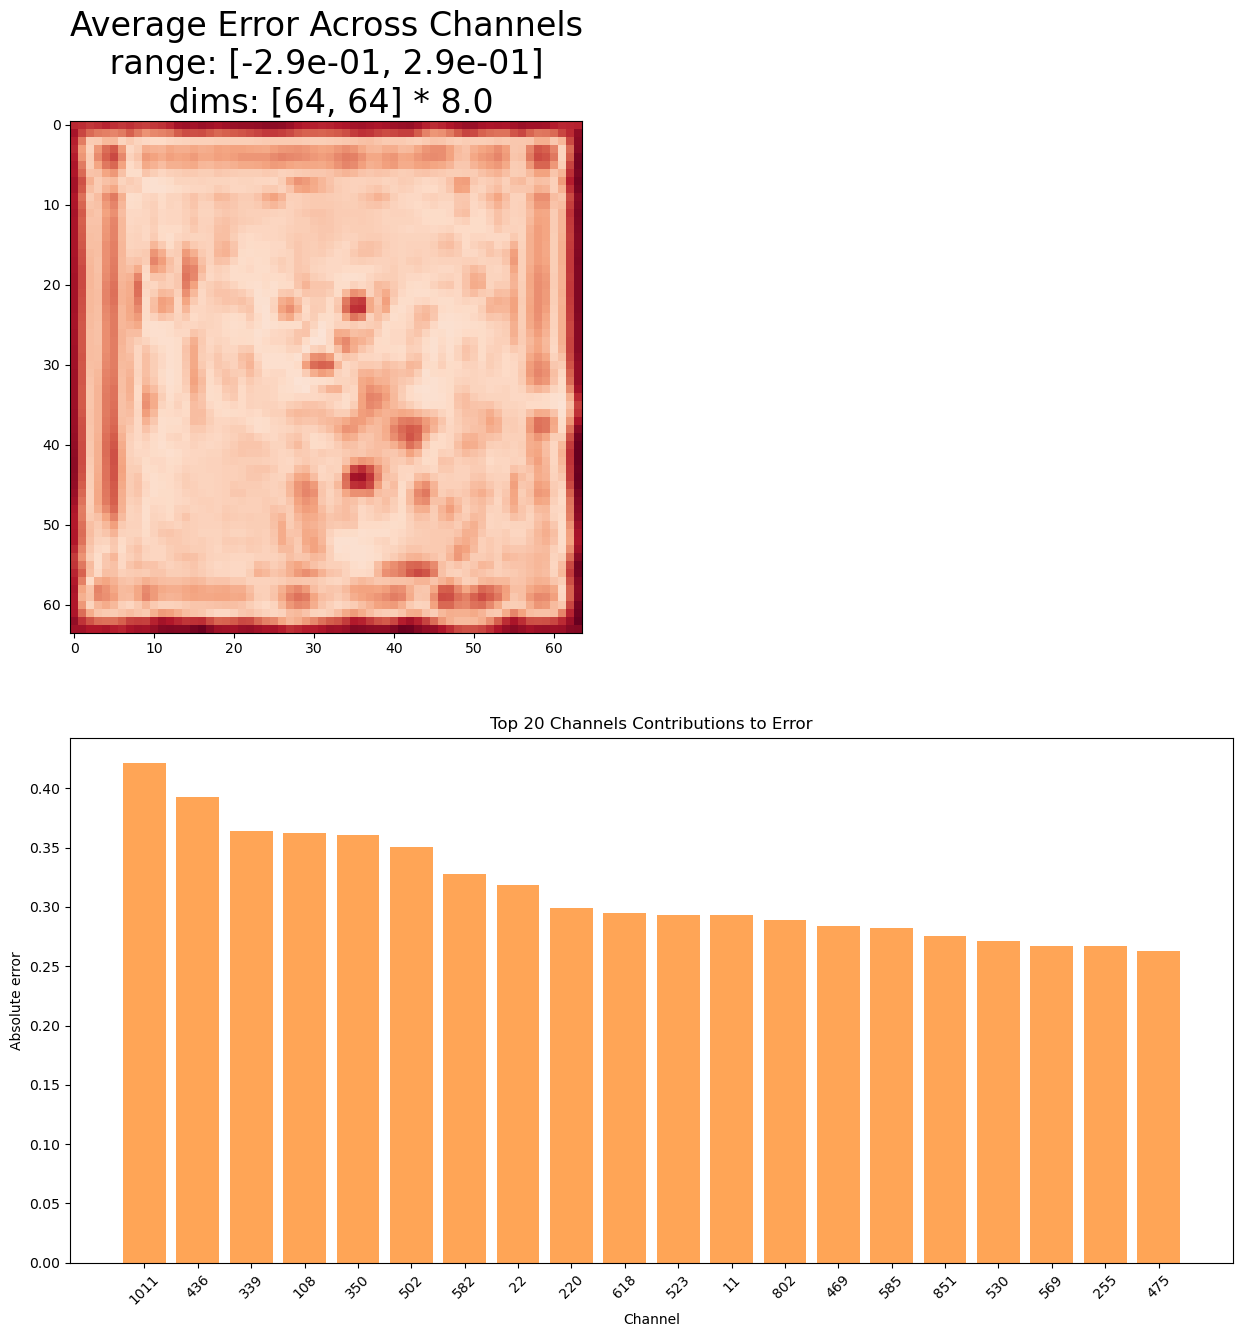

In [47]:
mdl.plot_representation(mdl(img));

In [61]:
po.tools.remove_grad(mdl)
mdl.eval()
po.tools.validate.validate_model(mdl, device=0)

In [62]:
met = po.synth.Metamer(img, mdl)
met.synthesize(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/mnt/home/wbroderick/plenoptic/src/plenoptic/tools/display.py:1024: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


(<Figure size 1700x500 with 5 Axes>,
 {'display_metamer': 0,
  'plot_loss': 1,
  'plot_representation_error': [3, 4, 2],
  'misc': []})

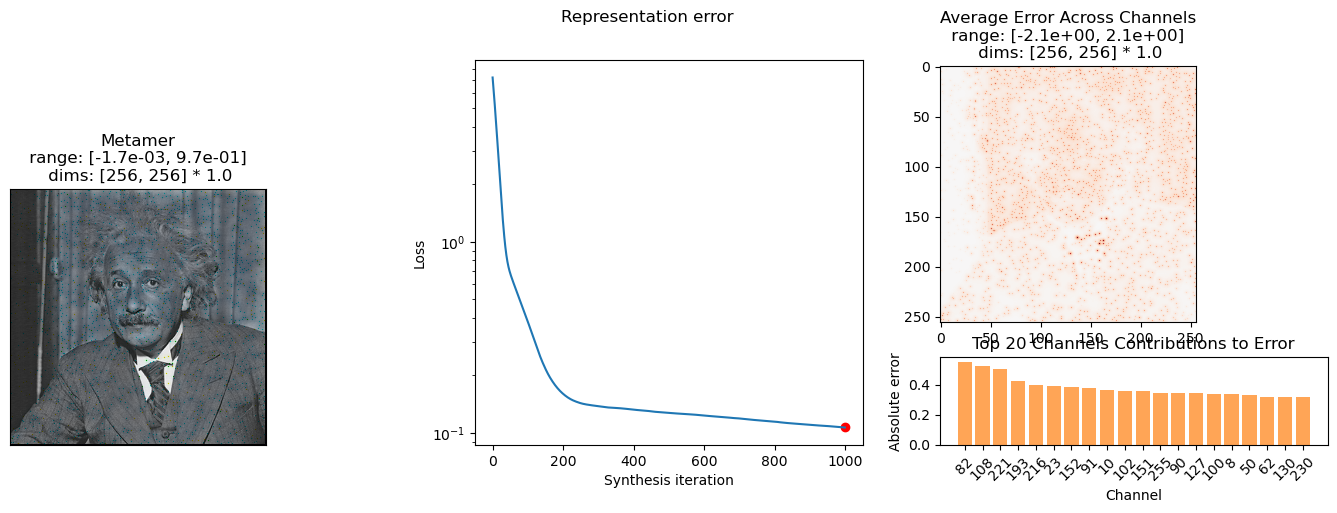

In [63]:
po.synth.metamer.plot_synthesis_status(met, ylim=False)